In [4]:
import copy
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unityagents import UnityEnvironment
from collections import namedtuple, deque

env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [82]:
BUFFER_SIZE = int(3e6)  # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
update_every = 20
SN = 0.25
ND = 0.99999

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300, 64), activ_in = F.relu, activ_out = torch.tanh):
        super(Actor, self).__init__()
        
        self.activ_in = activ_in
        self.activ_out = activ_out
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0], hu[1])
        self.hl2 = nn.Linear(hu[1], hu[2])
        self.output_layer = nn.Linear(hu[-1], action_size)
        
    def forward(self, state):
        x = torch.from_numpy(state).float().to(device)
        x = self.activ_in(self.input_layer(x))
        x = self.activ_in(self.hl1(x))
        x = self.activ_in(self.hl2(x))
        return self.activ_out(self.output_layer(x))  
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hu=(400, 300, 64), activ_in = F.relu):
        super(Critic, self).__init__()
        
        self.activ_in = activ_in
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0]+action_size, hu[1])
        self.hl2 = nn.Linear(hu[1], hu[2])          
        self.output_layer = nn.Linear(hu[-1], 1)
        
    def forward(self, state, action):
        x = torch.from_numpy(state).float().to(device)
        u = action#torch.from_numpy(action).float().to(device)
        
        x = self.activ_in(self.input_layer(x))
        x = torch.cat((x, u), dim=1)
        x = self.activ_in(self.hl1(x))
        x = self.activ_in(self.hl2(x))
        return self.output_layer(x)

In [ ]:
class Agent():
    def __init__(self, state_size, action_size, start_noise=SN, noise_decay=ND):
        self.state_size = state_size
        self.action_size = action_size
        
        ### Actor online and target networks
        self.actor_online = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=LR_ACTOR)
        
        ### Critic online and target networks
        self.critic_online = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC)
        
        
        ### Noise generator for exploration
        self.noise_scale = start_noise
        self.noise_decay = noise_decay
        
        ### Replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        self.tstep = 0
        
    def generate_noise(self):
        noise = np.random.normal(loc=0, scale=self.noise_scale, size=self.action_size)
        self.noise_scale *= self.noise_decay
        return noise

In [57]:
testactor = Actor(state_size, action_size).to(device)
testcritic = Critic(state_size, action_size).to(device)

teststate = env_info.vector_observations#.float().to(device)

In [58]:
testaction = testactor(teststate)
print(testaction)

tensor([[ 0.1122,  0.0016, -0.0736, -0.0825]], device='cuda:0',
       grad_fn=<TanhBackward>)


In [59]:
testq = testcritic(teststate, testaction)
print(testq)

tensor([[0.0227]], device='cuda:0', grad_fn=<AddmmBackward>)


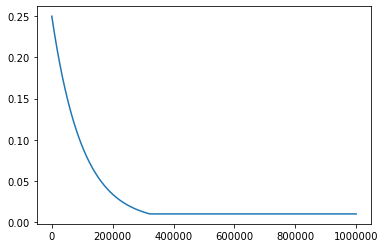

In [80]:
plt.plot([max(0.25*0.99999**x,0.01) for x in range(1,1000000)])

In [85]:
np.random.normal(loc=0, scale=SN, size=action_size)

array([ 0.20838365,  0.0576369 ,  0.3214352 , -0.31876569])